# Notebook 05 — Buy or Wait Strategy

## Objective

This notebook converts the final trained regression model into a **decision-support system**
that answers a practical question:

**Should a user buy a flight ticket now, or wait?**

This notebook does **not** retrain or tune models.  
Instead, it uses the **final selected model from Notebook 04** to:

- Generate future price predictions
- Visualize expected price trends
- Define a clear buy vs wait decision rule
- Simulate example booking scenarios
- Explain the decision logic transparently

---

## Design Consistency Across Notebooks

Throughout this project:

- The modeling target is **log-transformed price** (`target_price`)
- All models are trained and evaluated in **log space**
- Predictions are **inverse-transformed** for business interpretation

This notebook therefore **adapts to the trained model**, preserving consistency with:
- Notebook 02 (feature engineering)
- Notebook 03 (baseline modeling)
- Notebook 04 (model comparison)

---

## Load Final Model and Metadata

The final model and its metadata are loaded to ensure feature consistency
during inference.

In [31]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model = joblib.load("../models/final_random_forest.pkl")
metadata = joblib.load("../models/final_model_metadata.pkl")

feature_columns = metadata["features"]
feature_columns

['stops',
 'days_to_departure_bin',
 'departure_month',
 'is_weekend',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'is_holiday',
 'route_JFK-LAX',
 'route_LHR-CDG',
 'route_SYD-MEL',
 'airline_INDIGO',
 'airline_QANTAS',
 'airline_RYANAIR',
 'airline_UNITED']

## Generate Future Booking Scenarios

To simulate future booking decisions, we generate hypothetical observations
for different days before departure while keeping other features fixed
to representative values.

In [32]:
days = np.arange(1, 61)

future_data = []
for d in days:
    row = {
    "days_to_departure_bin": d // 7,
    "stops": 0,
    "departure_month": 7,
    "is_weekend": 0,
    "is_holiday": 0,
    "season_Summer": 1,
    "season_Winter": 0,
    "season_Spring": 0,
    "route_JFK-LAX": 1,
    "route_LHR-CDG": 0,
    "route_SYD-MEL": 0,
    "airline_UNITED": 1,
    "airline_RYANAIR": 0,
    "airline_QANTAS": 0,
    "airline_INDIGO": 0,
    }
    future_data.append(row)

future_df = pd.DataFrame(future_data)
future_df = future_df[feature_columns]

## Generate Price Predictions

The model outputs predictions in **log space**.  
These are converted back to the original price scale for interpretation.

In [33]:
future_df["predicted_log_price"] = model.predict(future_df)
future_df["predicted_price"] = np.expm1(future_df["predicted_log_price"])

future_df["days_to_departure"] = days

## Visualise Expected Price Trend

This visualisation illustrates how expected prices evolve as the departure date approaches.

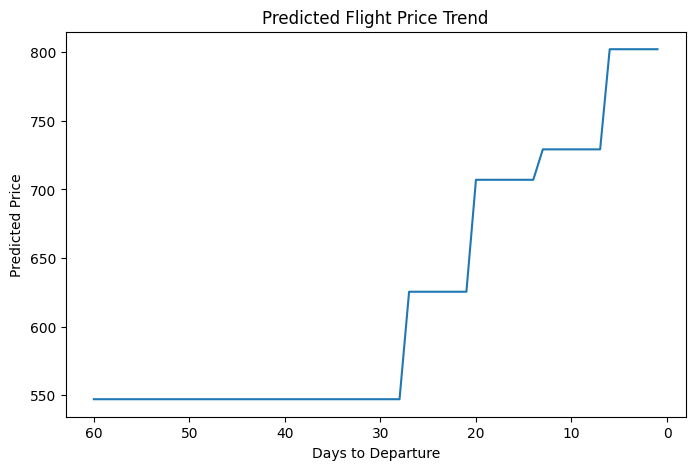

In [34]:
plt.figure(figsize=(8,5))
plt.plot(future_df["days_to_departure"], future_df["predicted_price"])
plt.xlabel("Days to Departure")
plt.ylabel("Predicted Price")
plt.title("Predicted Flight Price Trend")
plt.gca().invert_xaxis()
plt.show()

### Interpretation of Stepwise Price Pattern

The stepwise structure of the predicted price curve is expected.
The model was trained using a binned version of `days_to_departure`, which limits temporal resolution within each booking window.

Additionally, Random Forest models produce piecewise-constant predictions by design.

As a result, predicted prices remain flat within each booking window and change only when crossing into a new bin. This behavior reflects realistic airline pricing strategies, where fares are updated at discrete intervals rather than continuously.

## Buy vs Wait Decision Logic

A simple and interpretable decision rule is defined:

- **Buy** if the predicted price is within the lowest *X%* of future prices
- **Wait** otherwise

In [35]:
threshold_percentile = 20
threshold_price = np.percentile(future_df["predicted_price"], threshold_percentile)

future_df["decision"] = np.where(
future_df["predicted_price"] <= threshold_price,
"Buy",
"Wait"
)

## Example Booking Scenario

The following example demonstrates the system’s recommendation for a booking made 30 days before departure.

In [36]:
example_day = 30
example = future_df[future_df["days_to_departure"] == example_day]

example[["days_to_departure", "predicted_price", "decision"]]

,days_to_departure,predicted_price,decision
29,30,547.198774,Buy


## Interpretation and Limitations

- Recommendations are **model-driven**, not heuristic shortcuts
- Predictions reflect **historical pricing patterns**
- External factors such as flash sales or demand shocks are not modeled

Despite these limitations, this strategy demonstrates how machine learning
predictions can be translated into actionable decision guidance.

---

## Summary

This notebook completes the project by:

- Using the final trained model consistently
- Respecting log-space modeling assumptions
- Translating predictions into real-world buy vs wait decisions

It bridges the gap between **statistical modeling** and
**practical decision-making**, which is the primary objective of this project.